## AST4310, Autumn 2021, Project 5

Authored by (candidate number): **15508**.

### Header and imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units as u
from astropy import constants as con
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from matplotlib_inline.backend_inline import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 6)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import trapz, cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) #ignoring numpy warning from ragged nest of sequences

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

In [2]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    
    Modified to use np instead of numpy
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Modified to use np instead of numpy, and u, con instead of units, constants
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * u.K / temp
    electron_pressure = electron_density[..., nax] * con.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * u.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * u.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * u.cm ** 2 / u.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-con.h * con.c / (wave * con.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                       [-0.142631, 1.99381, -9.2846, 15.2827],
                       [-0.625151, 10.6913, -67.9775, 190.266, -197.789]])
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (u.cm ** 4) / u.dyn
    return (kappa_bf + kappa_ff).si

def voigt(damping, u):
    """
    Calculates the Voigt function.
    """
    z = (u + 1j * damping)
    return wofz(z).real

def read_atom(filename):
    """
    Reads atom structure from text file.
    Modified version of class Atom function.
    """
    tmp = np.loadtxt(filename, unpack=True)
    n_stages = int(tmp[2].max()) + 1
    max_levels = 0
    
    for i in range(n_stages):
        max_levels = max(max_levels, (tmp[2] == i).sum())
    
    chi = np.empty((n_stages, max_levels))
    chi.fill(np.nan)
    g = np.copy(chi)
    
    for i in range(n_stages):
        nlevels = (tmp[2] == i).sum()
        chi[i, :nlevels] = tmp[0][tmp[2] == i]
        g[i, :nlevels] = tmp[1][tmp[2] == i]

    chi = (chi / u.cm).to('aJ', equivalencies=u.spectral())
    chi_ion = chi[:, 0].copy()
    chi = chi - chi_ion[:, nax]
    return n_stages, g, chi, chi_ion

def compute_partition_function(temperature, g, chi):
    """
    Computes partition functions using the atomic level energies and
    statistical weights.
    Modified version of class Atom function.
    """
    temp = temperature[nax, nax]  # to allow broadcast
    return np.nansum(g[..., nax] * np.exp(-chi[..., nax] / con.k_B / temp), axis=1)

def compute_ionisation(temperature, electron_density, filename):
    """
    Computes ionisation fractions according to the Saha law.
    Modified version of class Atom function.
    """
    n_stages, g, chi, chi_ion = read_atom(filename)
    partition_function = compute_partition_function(temperature, g, chi)
    saha_const = ((2 * np.pi * con.m_e * con.k_B * temperature) / 
                  (con.h ** 2)) ** (3 / 2)
    nstage = np.zeros_like(partition_function) / u.m ** 3
    nstage[0] = 1. / u.m ** 3
    for r in range(n_stages - 1):
        nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                         partition_function[r + 1] / partition_function[r] * 
                         np.exp(-chi_ion[r + 1, nax] / 
                                   (con.k_B * temperature[nax])))
    return nstage / np.nansum(nstage, axis=0)

def compute_excitation(temperature, filename):
    """
    Computes the level populations relative to the ground state,
    according to the Boltzmann law.
    Modified version of class Atom function.
    """
    n_stages, g, chi, chi_ion = read_atom(filename)
    pfunc = compute_partition_function(temperature, g, chi)
    temp = temperature[nax, nax]
    g_ratio = g[..., nax] / pfunc[:, nax]  # relative to total number of atoms in this stage
    chi = chi[..., nax]
    return g_ratio * np.exp(-chi / (con.k_B * temp))

def compute_populations(temperature, electron_density, filename):
    """
    Computes relative level populations for all levels and all
    ionisation stages using the Bolzmann and Saha laws.
    Modified version of class Atom function.
    """
    return (compute_excitation(temperature, filename) * 
            compute_ionisation(temperature, electron_density, filename)[:, nax])

In [3]:
#loading dataset and extracting quantities used later
falc = read_table_units("falc.dat")
h_FALC       = falc['height'].to('km')
tau_500_FALC = falc['tau_500']
T_FALC       = falc['temperature']
N_H_FALC     = falc['hydrogen_density']
N_p_FALC     = falc['proton_density']
N_e_FALC     = falc['electron_density']
P_FALC       = falc['pressure']
P_ratio_FALC = falc['p_ratio']
v_turb_FALC  = falc['v_turb']

### Exercise 1: Continuum Optical Depth and Height of Formation

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Similar to what you've done in Project 4, compute the H$^-$ extinction as a function of height for the FALC model at at $\lambda$ = 0.5 μm. Now use it to compute the optical depth as function of height, $\tau_{500}$. Plot this against the $\tau_{500}$ from the FALC model (saved in `falc['tau_500']`). There should be a mismatch, discuss it. (Hint: recompute $\tau_{500}$ by adding also extinction from Thomson scattering.)

* Using the continuous extinction you computed above (from H$^-$ and Thomson scattering), use equation (4) to compute $<\!h\!>$, the  mean height of formation at 500 nm. What is the meaning of this value?

* Compute and plot the contribution function from equation (3) for 500 nm and compare with $<\!h\!>$ (plot it as a vertical line in the same figure). Discuss the shape of the curve and its meaning.

* Repeat the above normalised contribution plot for $\lambda$ = 1 μm, $\lambda$ = 1.6 μm, and $\lambda$ = 5 μm (all in same plot). Discuss the changes of the contribution functions and their cause.

* Compare the continuum intensity observations from Project 4 (exercise 2) with the predicted continuum intensities from the FALC model. Compute the total optical depth (H$^-$ and Thomson scattering) as in Project 4 (exercise 3), for the FALC model and for the same wavelengths in the observations. Assume LTE, so $S_\lambda \equiv B_\lambda$, and integrate equation (2) to get the emergent intensity. Convert your calculations and the observations to the units of  kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$ and plot them together. Discuss any differences between the two plots - what could be the underlying physical reasons?

</div>

In this exercise we aim to calculate emergent intensity using H$^-$ extinction and Thomson scattering. To do this we will use our findings from the previous project to calculate optical depth from H$^-$ and Thomson scattering with the FALC model data. From this we do a side-calculation of the mean height of formation, giving insight into at which depth the model intensity is created. Finally we integrate along optical depth to find the emergent intensity, which we compare with the solar continuum data `solspect.dat`.

We calculate the optical depth as a cumulative function of continuum extinction over height:

\begin{align*}
    \tau(h_0) = -\int_\infty^{h_0}\alpha_\lambda^c {\rm d}h = -\int_\infty^{h_0}(\alpha_\lambda^{H^-} + \alpha_\lambda^T) {\rm d}h
\end{align*}

Where the extinction $\alpha_\lambda^c$ is evaluated once for only the H$^-$ extinction and once for both H$^-$ and Thomson scattering. We plot the results at $\lambda = 500\ {\rm nm}$ as function of height and compare with the FALC optical depth:

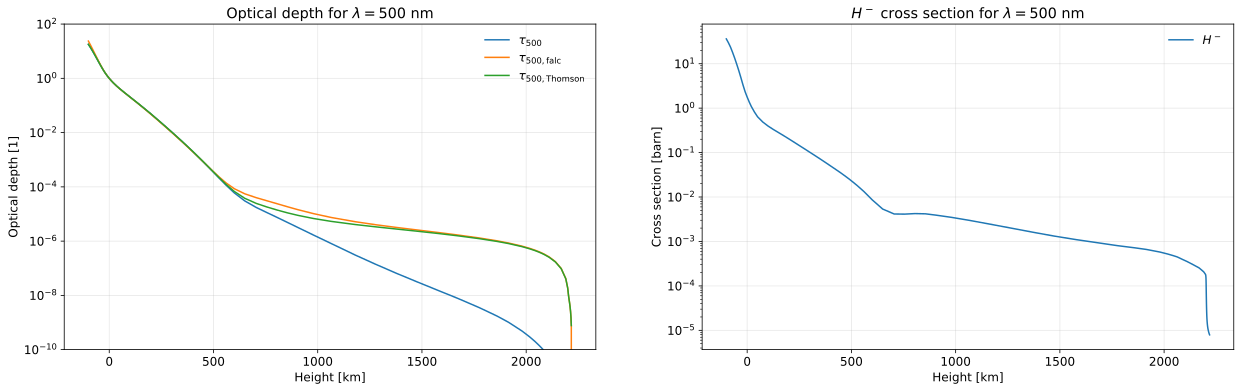

In [4]:
def extinction(lam, thomson=False):
    """Calculates H- extinction factor for given wavelength
       Optional argument to include Thomson cross section"""
    Hmin = u.Quantity([compute_hminus_cross_section(lam, Ti, ei)[0]for Ti, ei in zip(T_FALC, N_e_FALC)]).to('barn') #inserting T, N_e one by one

    alpha = Hmin.to('m2')*(N_H_FALC - N_p_FALC) #normal extinction
    if thomson:
        alpha += con.sigma_T*N_e_FALC #extinction w/thomson

    tau = -cumtrapz(alpha, h_FALC.to('m'))
    return alpha, tau

lam500 = 0.5 * u.micron
Hmin_height = u.Quantity([compute_hminus_cross_section(lam500, Ti, ei)[0] for Ti, ei in zip(T_FALC, N_e_FALC)]).to('barn')
_, tau_500 = extinction(lam500)
_, tau_500_thomson = extinction(lam500, thomson=True)

fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(h_FALC[1:], tau_500, label=r"$\tau_{500}$")
ax[0].plot(h_FALC, tau_500_FALC, label=r"$\tau_{500, {\rm falc}}$")
ax[0].plot(h_FALC[1:], tau_500_thomson, label=r"$\tau_{500, {\rm Thomson}}$")
ax[0].set_ylim(1e-10, 1e2)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_title(r"Optical depth for $\lambda = ${:.0f}".format(lam500.to('nm')))
ax[0].set_ylabel('Optical depth [1]')
ax[0].set_xlabel(f'Height [{ax[0].get_xlabel()}]')
ax[0].grid(alpha=0.3)

ax[1].plot(h_FALC, Hmin_height, label=r"$H^-$")
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_title(r"$H^-$ cross section for $\lambda = ${:.0f}".format(lam500.to('nm')))
ax[1].set_ylabel(f'Cross section [{ax[1].get_ylabel()}]')
ax[1].set_xlabel(f'Height [{ax[1].get_xlabel()}]')
ax[1].grid(alpha=0.3)

Here we have also plotted the H$^-$ cross section at $\lambda = 500\ {\rm nm}$ as function of height to show that the general shape is determined by its contribution. Looking at the optical depth figure, we see that the addition of Thomson scattering brings our model in line with the FALC model, aside from minor differences around $h = 800\ {\rm km}$. These minor differences are caused by a combination of many other smaller processes not accounted for in this project.

Next we find the mean height of formation, which can be intepreted as the weighted mean of height from which our intensity is created:

\begin{equation}
  <\!h\!> \, \equiv \,
       \frac{\int_0^\infty h \, (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
                      {\int_0^\infty (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
     = \frac{\int_0^\infty h \, S_\lambda e^{-\tau_\lambda}
                \rm{d} \tau_\lambda}
            {\int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda}.
\end{equation}

In this calculation we approximate the source function as black-body radiation since the processes are entirely thermal. We use the optical depth at $\lambda = 500\ {\rm nm}$ for combined H$^-$ and Thomson extinction/scattering:

In [5]:
S_times_exp = BlackBody(T_FALC)(lam500)[1:] * np.exp(-tau_500_thomson)
upper = trapz(h_FALC[1:]*S_times_exp, tau_500_thomson)
lower = trapz(S_times_exp, tau_500_thomson)
h_mean = upper/lower
h_mean

<Quantity 4.02662238 km>

We find the mean height to be at ~$4 {\rm km}$ for our chosen parameters. It makes sense that this value is near the surface of the star, as the surface is defined to be the height at which half the formed intensity escapes without scattering (or $\tau \approx 2/3$). The difference in height is caused both by few model points (lack of precision) and the chosen wavelength, which we will look at next.

The contribution function is calculated as the derivative of intensity with respect to height:

\begin{align*}
    \frac{{\rm d}I_\lambda}{{\rm d}h} = S_\lambda e^{-\tau_\lambda}\alpha_\lambda
\end{align*}

Which can be interpreted as the contribution of each height to the total intensity, with respect to the optical depth at that layer. This can be seen easier by using $S_\lambda = j_\lambda/\alpha_\lambda$, where the extinction coefficients would cancel and leave only the emission $j_\lambda$ times the extinction.

As we evaluate this function we again use the approximation $S_\lambda \approx B_\lambda$ due to thermal processes (with $B_\lambda$ being Planck's law), and use a set of different wavelengths:

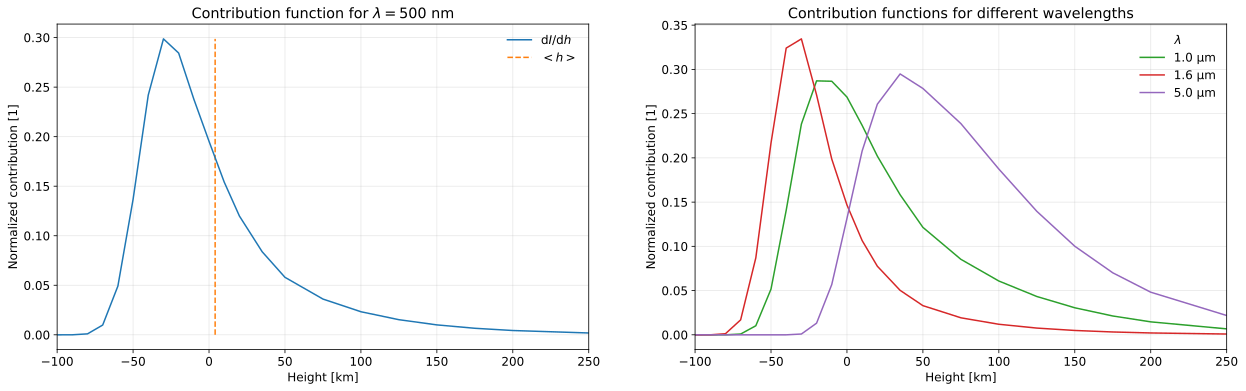

In [6]:
def contribution(lam):
    """Calculates normalized contribution function for given wavelength"""
    alpha, tau = extinction(lam, thomson=True)
    cont = BlackBody(T_FALC)(lam)[1:]*np.exp(-tau)*alpha[1:]
    cont /= trapz(cont, tau) #normalizing by area
    return cont

dIdh_500 = contribution(lam500)
fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(h_FALC[1:], dIdh_500, label=r"${\rm d}I/{\rm d}h$")
ax[0].vlines(h_mean, 0, max(dIdh_500), linestyle="--", color="C1", label=r"$<h>$")
ax[0].legend()
ax[0].set_ylabel(r"Normalized contribution [1]")
ax[0].set_xlabel(f"Height [{ax[0].get_xlabel()}]")
ax[0].set_title(r"Contribution function for $\lambda = ${:.0f}".format(lam500.to('nm')))
ax[0].set_xlim(-100, 250)
ax[0].grid(alpha=0.3)

dIdh_1000 = contribution(1.0 * u.micron)
dIdh_1600 = contribution(1.6 * u.micron)
dIdh_5000 = contribution(5.0 * u.micron)
ax[1].plot(h_FALC[1:], dIdh_1000, color="C2", label="1.0 µm")
ax[1].plot(h_FALC[1:], dIdh_1600, color="C3", label="1.6 µm")
ax[1].plot(h_FALC[1:], dIdh_5000, color="C4", label="5.0 µm")
ax[1].legend(title=r"$\lambda$")
ax[1].set_ylabel(r"Normalized contribution [1]")
ax[1].set_xlabel(f"Height [{ax[1].get_xlabel()}]")
ax[1].set_title("Contribution functions for different wavelengths")
ax[1].set_xlim(-100, 250)
ax[1].grid(alpha=0.3)

In the left figure we have plotted the contribution function for our previous wavelength of $\lambda = 500\ {\rm nm}$ along with the height of mean formation. We can see that the mean height does not equal the peak of this graph, but is shifted towards a higher altitude. While the lower heights have a higher contribution in terms of emission, they also have a longer optical depth, leaving the mean height of formation as a weighted average of these factors.

This can be seen clearer in the right plot where the functions seem to shift in height for different wavelengths. The difference is due to the varying extinction facing these wavelengths, where less extinction means the sun is more "transparent" at these values. We can see that for the three values chosen, the one which peaks for least height is the middle value $\lambda = 1.6\ {\rm \mu m}$. The reason for this is that this wavelength is where the dominant extinction transitions from H$^-$ bound-free to H$^-$ free-free, leaving a local minimum:

<img src="https://tiagopereira.space/ast4310/images/gray8-6a.svg" width=600px>

As we see deeper into the sun we also see higher temperatures, meaning the expected contribution would be larger. This is not shown in these figures however as the plots have been normalized by curve area for easier comparison.

Using what we've found so far, we calculate the total emergent intensity as function of wavelength. This is done by integrating the source function for optical depth:

\begin{align*}
    I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}{\rm d}\tau
\end{align*}

We evaluate this with our approximation $S_\lambda \approx B_\lambda$ and plot it alongside the solar spectrum `solspect.dat`:

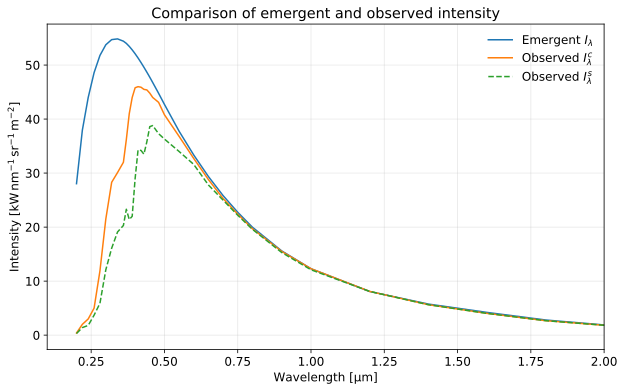

In [7]:
tmp = np.genfromtxt("solspect.dat") # loading observations
lam_obs = tmp[:, 0] * u.micron #µm from observations
conv = -np.gradient(lam_obs, lam_obs.to("Hz", equivalencies=u.spectral())) #wavelength -> frequency conversion factor

BB = u.Quantity([BlackBody(T_FALC)(lami)[1:] for lami in lam_obs])
tau = u.Quantity([extinction(lami, thomson=True)[1] for lami in lam_obs])
I = trapz(BB*np.exp(-tau), tau, axis=1)
fig, ax = plt.subplots()
ax.plot(lam_obs, (I/conv).to("kW m-2 nm-1 sr-1"), label=r"Emergent $I_\lambda$")

I_sm   = tmp[:, 3] * 10**10 * u.erg * u.s**-1 * u.cm**-2 * u.micron**-1 * u.sr**-1 #smoothed intensity
I_cont = tmp[:, 4] * 10**10 * u.erg * u.s**-1 * u.cm**-2 * u.micron**-1 * u.sr**-1
ax.plot(lam_obs, I_cont.to("kW m-2 nm-1 sr-1"),  "-", label=r"Observed $I_\lambda^c$")
ax.plot(lam_obs,   I_sm.to("kW m-2 nm-1 sr-1"), "--", label=r"Observed $I_\lambda^s$")
ax.set_title("Comparison of emergent and observed intensity")
ax.set_xlabel(r"Wavelength [${\rm \mu m}$]")
ax.set_ylabel(f"Intensity [{ax.get_ylabel()}]")
ax.legend()
ax.set_xlim(0.1, 2.0)
ax.grid(alpha=0.3)

Here the observed intensities $I_\lambda^s, I_\lambda^c$ refer to the "smoothed" and "true" continuum intensities respectively (see project 4). We can see that our emergent intensity matches the spectra well for $\lambda > 0.75\ {\rm \mu m}$, but diverge below this. This is mainly due to the large amount of spectral lines in the short wavelength end, where the limited spectral resolution cause a seemingly continual extinction. This would not be taken into account for in the reconstructed intensities from `solspect.dat` since the lines could not be resolved, but is visible in our model.

### Exercise 2: The Na I partition function

The partition function $U_r$ is important to correctly compute a spectral line profile. An accurate value relies on having the atomic level energies for several excited states, but in our simple atom `NaI_atom.txt` we have only two excited states in neutral sodium. Is it good enough? [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) gives the following recipe for the Na I partition function: 

$$
\log U_\mathrm{Na\,I}(T) \approx c_0 + c_1 \log \theta + c_2 \log^2 \theta + c_3 \log^3 \theta + c_4 \log^4 \theta,
$$

with $\theta \equiv 5040./T$ (with $T$ in K) and $c_0 = 0.30955$, $c_1=-0.17778$, $c_2=1.10594$, $c_3=-2.42847$ and $c_4=1.70721$. In the 2005 version of the book, these fits were replaced by a table, which you can use if you prefer.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Check how far we are from a better partition function by comparing the approach followed in Project 1 with the `NaI_atom.txt` file with Gray's recipe at 5000 K and 6000 K.

</div>

The purpose of this exercise is to validate that our method of calculating the partition function with limited levels/stages fits well with Gray's recipe, which is a good approximation for the full partition function.

We evaluate Gray's recipe alongside the partition function for our levels from `NaI_atom.txt` at temperatures $5000\ {\rm K}$ and $6000\ {\rm K}$, which are rough solar surface temperatures:

In [8]:
def log_U_NaI(T):
    c0 =  0.30955
    c1 = -0.17778
    c2 =  1.10594
    c3 = -2.42847
    c4 =  1.70721
    log_theta = np.log10(5040/T)
    return c0 + c1*log_theta + c2*log_theta**2 + c3*log_theta**3 + c4*log_theta**4

NaI = np.genfromtxt("NaI_atom.txt")
E = NaI[:, 0] * u.cm**-1; g = NaI[:, 1]; s = NaI[:, 2]
E = E.to("J", equivalencies=u.spectral())
T_Ur = np.array([5000, 6000]) * u.K
Ur = compute_partition_function(T_Ur, g, E)[0]

print("   log(Ur)         5000 K     6000 K")
print("NaI_atom.txt:  ", np.log10(Ur))
print("Gray's recipe: ", log_U_NaI(T_Ur.value))

   log(Ur)         5000 K     6000 K
NaI_atom.txt:   [0.3107939  0.32276461]
Gray's recipe:  [0.30894793 0.33046313]


We can see that for this temperature range our partition function fits well with Gray's recipe, with only minor deviations of order ~$0.01$. This means that our limited partition of Na I is a fair approximation for our purposes.

### Exercise 3: Computing the Na I D line profile

You now have all the ingredients to compute the Na I D$_1$ line profile from a model solar atmosphere, the FALC model. Such calculation, also known as the predicted spectrum or synthetic spectrum, will give the line profile you would expect to observe if the FALC was a real star. It can then be used to compare with actual observations, where a good match would suggest the model reproduces the mean atmospheric stratification of the star. An accurate calculation of a line profile thus depends critically on knowning many details: from a good model of the star's atmosphere, accurate knowledge about atomic physics and properties of the transition, and detailed radiative transfer calculations. In this exercise, you will see if all of those ingredients are up to the task: compute the Na I D$_1$ line profile and compare with observations.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Code all the ingredients above together with the continuum exctinction from exercise 1 into appropriate functions for each quantity (line extinction, continuum extinction, profile, level populations, integration). 

* Use equation (2) to compute the disk-centre ($\mu$ = 1) intensity for the Na I D$_1$ line for the FALC model. Calculate the profile for about 200 wavelength points, centred at the line core, and extending 0.1 nm on either side. Plot the normalised line profile against the observations from `int_nad.dat` and discuss the differences. Explain why your computed profile has a line-centre reversal.

* Use equation (5) to compute $\mu$=0.2 intensity for the Na I D$_1$ line for the FALC model. Plot the line profiles for $\mu$=1 and 0.2 in an absolute scale and discuss the differences.

* Use equation (5) to compute the limb darkening $I_\lambda(0, \mu)/I_\lambda(0, \mu=1)$ for two wavelengths in the Na I D$_1$ line: in the far blue wing, and in the line core. Calculate $I_\lambda(0, \mu)$ for several equally-spaced values of $\mu$, e.g. $\mu=0.1, 0.2, ..., 1.0$. Plot the limb darkening (also known as centre-to-limb variation) as a function of $\mu$ and separately as a function of radius of the apparent solar disk, $r/R_\odot= \sin\theta$. Explain the limb darkening and its variation with wavelength.

* Use the flux integration described above to compute the astrophysical flux $F^+_\lambda$ for the Na I D$_1$ line for the FALC model. Plot the normalised flux against the normalised disk-centre intensity and discuss any differences. Why are they not the same?

</div>

In this exercise we aim to combine our findings so far into a synthetic line model. We will compare this with a real observation `int_nad.dat` and look at effects of different viewing angles. By varying the viewing angle we express the limb darkening and its effects on the line core and continuum. Integrating across the viewing angle we can then also find the astrophysical flux, which we compare with the disk-centre intensity.

The central part we need to evaluate is the line extinction:

\begin{align*}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec}\frac{\lambda^2}{c}\frac{n_l^\mathrm{LTE}}{N_E}N_H A_E f_{lu}\frac{H(a, v)}{\sqrt{\pi}\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right]
\end{align*}

This equation consists of the electron charge $e$, vacuum permittivity $\varepsilon_0$, electron mass $m_e$, light speed $c$, wavelength $\lambda$, LTE population fraction $n_l^\mathrm{LTE}/N_E$, hydrogen number density $N_H$, element abundance $A_E$, oscillator strength $f_{lu}$, Voigt function $H(a, v)$, pi $\pi$, doppler width $\Delta\lambda_D$, Euler's constant $e$, the Planck constant $h$, the Boltzmann constant $k_B$, and temperature $T$.

Most of these are known quantities and functions previously used, but we use a few quantities specific to our Na I atom:

|                  | Na I D$_1$ | Na I D$_2$ |
|------------------|-----------:|-----------:|
| Air wavelength (nm)  | 589.755         | 589.158  |
| Lower level      |  3s\,2S$_{1/2}$ | 3s\,2S$_{1/2}$ |
| Upper level      |  3p\,2P$^{\rm o}_{1/2}$ | 3p\,2P$^{\rm o}_{3/2}$ |
| $\chi_{1,l}$ (aJ)| 0     | 0      |
| $\chi_{1,u}$ (aJ)| 0.3368| 0.3371 |
|   $g_l$          | 2     | 2      |
|   $g_u$          | 2     | 4      |
| $f_{lu}$         | 0.318 | 0.631  |

And element abundance $A_E = 1.7378 \cdot 10^{-6}$. We implement the line extinction and calculate the emergent intensity as in exercise 1, zooming in on each line $\lambda_0 \pm 0.1\ {\rm nm}$:

In [9]:
def extinction(lam, thomson=False, extra_alpha=0):
    """Calculates H- extinction factor for given wavelength
       Optional argument to include Thomson cross section
       or to add another extinction to total
       
       Modified version of earlier function"""
    Hmin = u.Quantity([compute_hminus_cross_section(lam, Ti, ei)[0]for Ti, ei in zip(T_FALC, N_e_FALC)]).to('barn')
    
    alpha = u.Quantity([Hmini.to('m2')*(N_H_FALC - N_p_FALC) for Hmini in np.transpose(Hmin)])
    if thomson:
        alpha += con.sigma_T*N_e_FALC #extinction w/thomson

    alpha += extra_alpha
    
    tau = -cumtrapz(alpha.to("m-1"), h_FALC.to('m'), axis=1)
    return alpha, tau

def line_extinction(lam, height, filename, lam0, m, f_lu, g_l, g_u, A_E, l_l, l_u, Z, chi_inf, chi_u, chi_l):
    """
    Calculates line extinction given line parameters.
    """
    idx = np.argmin(abs(h_FALC - height)) # where height matches best with FALC
    N_H = N_H_FALC[idx]
    N_e = N_e_FALC[idx]
    T = T_FALC[idx]
    P_g = (P_FALC*P_ratio_FALC)[idx]
    
    LTE_pop_frac = compute_populations(T, N_e, filename)
    
    nu_star2 = 2.18 * u.aJ * Z**2 / (chi_inf - chi_u)
    nl_star2 = 2.18 * u.aJ * Z**2 / (chi_inf - chi_l)
    rl2 = nl_star2/(2*Z**2) * (5*nl_star2 + 1 - 3*l_l*(l_l+1))
    ru2 = nu_star2/(2*Z**2) * (5*nu_star2 + 1 - 3*l_u*(l_u+1))
    
    gamma_rad = 6.67e13 * g_l/g_u * f_lu/lam.to("nm").value**2 * u.s**-1
    gamma_vdW = 10**(6.33 + 0.4*np.log10(ru2 - rl2) + np.log10(P_g.to("Ba").value) - 0.7*np.log10(T.to("K").value)) * u.s**-1
    gamma = gamma_rad + gamma_vdW

    dlam_D = lam0/con.c * np.sqrt(2*con.k_B*T/m + v_turb_FALC[idx]**2)
    damping = lam**2/(4*np.pi*con.c) * gamma/dlam_D
    u_ = (lam - lam0)/dlam_D
    
    return (con.e.si**2/(4*con.eps0*con.m_e*con.c) * lam**2/con.c * LTE_pop_frac * N_H * A_E * f_lu * voigt(damping, u_)/(np.sqrt(np.pi) * dlam_D) * (1-np.exp(-con.h*con.c/(lam*con.k_B*T)))).to("Mm-1")

def NaI_line(mu, D2=False, lam_override=None):
    """
    Calculates line profile of Na I D1 line (and optionally D2) given
    a viewing angle µ. Default wavelength range line centre +- 0.1 nm, with
    optional argument to evaluate for other range/values.
    """
    m       = 22.99*1.6605e-27 * u.kg
    g_l     = 2
    A_E     = 1.7378e-6
    l_l     = 0
    l_u     = 1
    Z       = 1
    chi_inf = 0.823 * u.aJ
    chi_l   = 0 * u.aJ
    
    if not D2: #D1
        lam0  = 589.755 * u.nm
        f_lu  = 0.318
        g_u   = 2
        chi_u = 0.3368 * u.aJ
        lower_pop = 1
    else: #D2
        lam0  = 589.158 * u.nm
        f_lu  = 0.631
        g_u   = 4
        chi_u = 0.3371 * u.aJ
        lower_pop = 2

    dlam = 0.1*u.nm
    lam = np.linspace(lam0-dlam, lam0+dlam, 200)
    conv_long = -np.gradient(lam, lam.to("Hz", equivalencies=u.spectral()))
    if lam_override != None: # if you want to replace lambda, needs to be array
        lam = lam_override
        conv_long = 1 * conv_long.unit

    BB = u.Quantity([BlackBody(T_FALC)(lami)[1:] for lami in lam])
    line_ext = np.transpose(np.array([np.nansum(line_extinction(lam, hi, "NaI_atom.txt", lam0, m, f_lu, g_l, g_u, A_E, l_l, l_u, Z, chi_inf, chi_u, chi_l)[0, :lower_pop], axis=0) for hi in h_FALC])) * u.Mm**-1

    tau = extinction(lam, thomson=True, extra_alpha=line_ext)[1]
    I = trapz(BB*np.exp(-tau/mu), tau/mu, axis=1)/conv_long
    return lam, I.to("nW m-2 micron-1 sr-1")

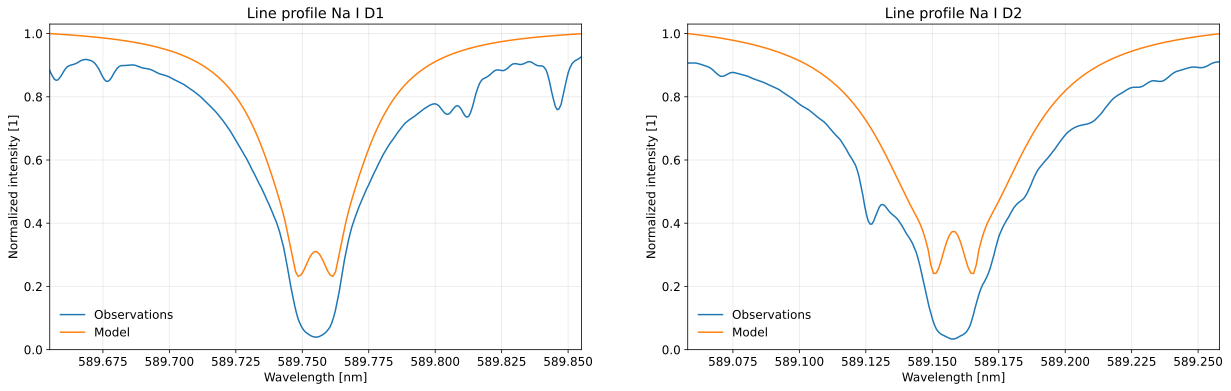

In [10]:
lam_D1, I_D1 = NaI_line(1)
lam_D2, I_D2 = NaI_line(1, True)

wnum, _, sp_obs, _ = np.loadtxt("int_nad.dat", unpack=True)
wnum = wnum / u.cm
wave = wnum.to("nm", equivalencies=u.spectral())

fig, ax = plt.subplots(1, 2, figsize=(21, 6))
ax[0].plot(wave, sp_obs, label="Observations")
ax[0].plot(lam_D1, (I_D1)/np.nanmax(I_D1), label="Model")
ax[0].set_xlim(lam_D1[[0, -1]])
ax[0].set_ylim(0.0, 1.03)
ax[0].set_title("Line profile Na I D1")
ax[0].set_xlabel(f"Wavelength [{lam_D1.unit}]")
ax[0].set_ylabel("Normalized intensity [1]")
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(wave, sp_obs, label="Observations")
ax[1].plot(lam_D2, (I_D2)/np.nanmax(I_D2), label="Model")
ax[1].set_xlim(lam_D2[[0, -1]])
ax[1].set_ylim(0.0, 1.03)
ax[1].set_title("Line profile Na I D2")
ax[1].set_xlabel(f"Wavelength [{lam_D2.unit}]")
ax[1].set_ylabel("Normalized intensity [1]")
ax[1].legend()
ax[1].grid(alpha=0.3)

Overlaid are real observations of these lines, both normalized by the continuum for comparison. Further in this exercise we will only consider line Na I D1, and Na I D2 is only added for fun. Overall the line fits well with the observations, being of similar shape and size. There is some continuum absorption across the plotted interval, leaving the observations slightly dimmer overall. In addition the shape is slightly misformed along the sides, potentially caused by our approximations in partition function. Though the clearest difference is naturally the line-core reversal observed in the model, which we will discuss in more detail.

It is tempting to say this is an emission profile in the line core, but as the observations show this is not the case. Rather it is an artifact of our previous assumption regarding the source function, as it is only valid in a local thermal equilibrium. We approximated the source function as the Planck function $S_\lambda \approx B_\lambda$, but this no longer holds in the upper solar atmosphere. Planck's law only takes temperature and wavelength into account, and since the solar atmosphere eventually increases in temperature it assumes increased emission. This creates the reversed line core seen for our model due to the wrong assumption for upper atmosphere.

Next we wish to see how this profile is affected by the viewing angle $\mu = \cos(\theta)$. It is implemented as a factor of the optical depth in emergent intensity:

\begin{align*}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
\end{align*}

We evaluate this for both disc centre $\mu = 1$ and near the disc edge $\mu = 0.2$:

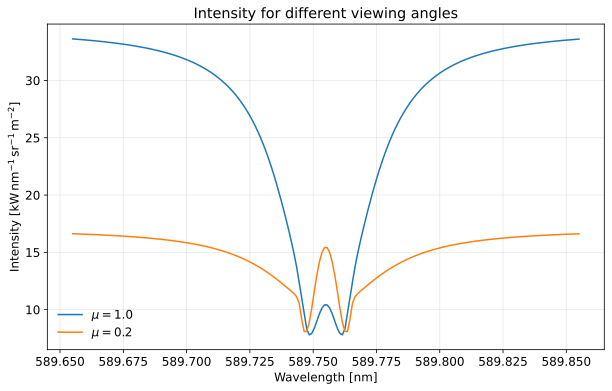

In [11]:
lam, I1 = NaI_line(1.0)
lam, I2 = NaI_line(0.2)

fig, ax = plt.subplots()
ax.plot(lam, I1.to("kW m-2 nm-1 sr-1"), label=r"$\mu=1.0$")
ax.plot(lam, I2.to("kW m-2 nm-1 sr-1"), label=r"$\mu=0.2$")
ax.set_title("Intensity for different viewing angles")
ax.set_xlabel(f"Wavelength [{lam.unit}]")
ax.set_ylabel(f"Intensity [{ax.get_ylabel()}]")
ax.legend()
ax.grid(alpha=0.3)

Unlike previous figures we use absolute scale as we wish to look at the change in continuum with viewing angle. We see that the continuum is much lower compared to the disc-centre intensity. This is due to the increased effective optical depth. As we saw previously, the mean height of formation is near the surface of the star. When we observe towards the limb of the sun the path to the surface is elongated, leading to larger optical depth and extinction of surface intensity. This effect is called limb darkening.

Note also the increase of intensity in the reversed line core. This is a related but opposite effect called limb brightening, which is present for some spectral lines emitted by the surrounding hot atmosphere. In our case however it is entirely fictional, as we discussed previously.

Calculating the intensity for even more angles we can plot the relative intensity to disc-centre $I_\lambda(0, \mu)/I_\lambda(0, \mu=1)$ for both core and continuum:

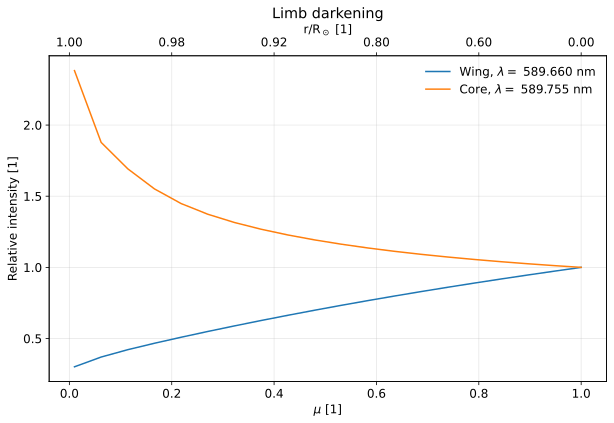

In [12]:
mu_list = np.linspace(0.01, 1, 20)
lam_override = np.array([589.660, 589.755]) * u.nm

I_wing = np.zeros_like(mu_list)
I_core = np.zeros_like(mu_list)
for i, mu in enumerate(mu_list):
    I = NaI_line(mu, False, lam_override)[1]
    I_wing[i], I_core[i] = I.value

I0 = NaI_line(1, False, lam_override)[1]
I_wing /= I0[0].value
I_core /= I0[1].value

fig, ax = plt.subplots()
ax.plot(mu_list, I_wing, label=r"Wing, $\lambda =$ {:.3f} nm".format(lam_override[0].to('nm').value))
ax.plot(mu_list, I_core, label=r"Core, $\lambda =$ {:.3f} nm".format(lam_override[1].to('nm').value))
ax.set_xlabel(r"$\mu$ [1]")
ax2 = ax.twiny()
new_tick_locations = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(["%.2f" % z for z in np.sin(np.arccos(new_tick_locations))])
ax2.set_xlabel(r"r/R$_\odot$ [1]")
ax.set_title("Limb darkening")
ax.set_ylabel(r"Relative intensity [1]")
ax.legend()
ax.grid(alpha=0.3)

Here we see the effects of limb darkening and imaginary limb brightening for relative intensity. An additional axis of apparent solar disc $r/R_\odot = \sin(\theta)$ has also been added. As the angle increases we see that the two wavelengths deviate from the disc-centre, each changing by a factor $2-3$. Assuming a continual change we'd then expect there to be a point between these where the intensity stays constant, and from our previous plot we can see this is the case for near-core wavelengths ~$589.740\ {\rm nm}$.

Finally we wish to calculate the astrophysical flux by integrating across the solar disc:

\begin{align*}
    F_\lambda^+ = 2\int_0^1\mu I_\lambda(0, \mu)\, \mathrm{d}\mu
\end{align*}

To get accurate results it is not enough to integrate this numerically with a trapezoidal method, as the function $\mu I(0, \mu)$ is ill-fitted with straight segments. Instead we use a non-equidistant Gaussian quadrature:

\begin{align*}
    \int_{-1}^1 f(x)\, \mathrm{d}x \approx \sum_{i=1}^{n}w_i f(x_i)
\end{align*}

Where the function is evaluated at a set of point $x_i$ with corresponding weights $w_i$. We do a small modification to the weights and points to modify the integration limits $[-1, 1] \rightarrow [0, 1]$:

\begin{align*}
    x'_i &= \frac{x_i}{2} +\frac{1}{2} \\
    w'_i &= \frac{w_i}{2}
\end{align*}

We use three points in our quadrature and plot the flux against intensity:

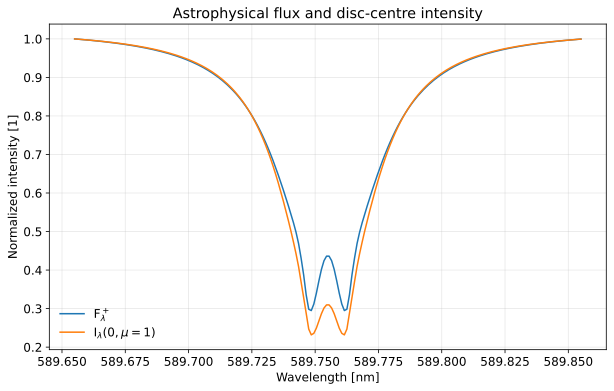

In [13]:
mu_gauss = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)]) / 2 + 0.5  
weight_gauss = (np.array([5/9, 8/9, 5/9]) / 2)
lines = np.zeros((3, 200))
for i in range(len(lines)):
    lines[i] = NaI_line(mu_gauss[i])[1]*mu_gauss[i]
F_ast = 2*np.nansum(weight_gauss[..., nax] * lines, axis=0)
I = NaI_line(1)[1]
plt.plot(lam, F_ast/max(F_ast), label=r"F$^+_\lambda$")
plt.plot(lam, I/max(I), label=r"I$_\lambda(0, \mu=1)$")
plt.title("Astrophysical flux and disc-centre intensity")
plt.xlabel(f"Wavelength [{lam.unit}]")
plt.ylabel("Normalized intensity [1]")
plt.legend()
plt.grid(alpha=0.3)

We see that the flux has the same overall shape as the intensity, but with an increased line core. This is since the integration over the solar disc favors the core over the continuum. We previously found the continuum to decrease with viewing angle while the core increased. Since the integration is over apparent area, the outer angles contribute more to the flux. This will cause the core to increase relative to the continuum, which in a plot normalized for continuum causes the core to seemingly increase.